# Предсказание уровня зарплаты по описанию вакансии

## Описание исследования
Представлен набор данных с описаниями вакансий и сопутствующими характеристиками. Необходимо построить модель, которая будет точно предсказывать ожидаемый уровень стартовой зарплаты. Каждое описание вакансии содержит ценную информацию, такую как требуемые навыки, обязанности на работе и данные о компании.

## Цель исследования
Решить задачу регрессии по прогнозированию уровня зарплаты на основе текстовых данных, информации о вакансии.

## Ход исследования
1. Загрузка данных
2. Предобработка и исследовательский анализ
4. Подготовка данных
5. Обучение моделей
6. Получение предсказания на тестовой выборке

## Описание данных
- id - уникальный номер вакансии (категориальный признак)
- vacancyName - название вакансии (категориальный признак)
- codeProfessionalSphere - профессиональная сфера (категориальный признак)
- salary - уровень зарплаты, целевой признак (количественный признак)
- busyType - тип занятости (категориальный признак)
- educationRequirements - требования к образованию (категориальный признак)
- hardSkills - навыки, нужные для работы (категориальный признак)
- softSkills - навыки для взаимодействия (категориальный признак)
- scheduleType - форма занятости (категориальный признак)
- companyBusinessSize - размер компании (категориальный признак)
- regionName - наименование региона (категориальный признак)
- qualifications - качества кандидата (категориальный признак)
- responsibilities - трудовые обязанности (категориальный признак)

In [1]:
# импорт библиотек

# работа с данными
import numpy as np
import pandas as pd
from scipy.sparse import hstack, save_npz, csr_matrix

# инструменты анализа
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# работа с графикой
from matplotlib import pyplot as plt

# подготовка данных
from sklearn.model_selection import train_test_split
from category_encoders import CatBoostEncoder
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# пайплайны
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# модели машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

# метрика для оценки прогноза
from sklearn.metrics import root_mean_squared_error

c:\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# константы
TEST_SIZE = 0.25 
RANDOM_STATE = 42

In [3]:
# обзор директории
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1. Загрузка данных

In [4]:
# загрузка данных тренировочной выборки
try:
    train = pd.read_csv("train.csv", index_col='id')
except:
    train = pd.read_csv("/kaggle/input/trudvsem/train.csv", index_col='id')

In [5]:
train.shape

(382090, 12)

In [ ]:
# оценка базового прогноза путем заполнения медианными значениями
baseline_prediction = [train['salary'].median()] * len(train)
baseline_prediction
root_mean_squared_error(train['salary'], baseline_prediction)

28981.40366027144

In [6]:
# загрузка данных тестовой выборки
try:
    test = pd.read_csv("test.csv", index_col='id')
except:
    test = pd.read_csv("/kaggle/input/trudvsem/test.csv", index_col='id')

## 2. Предобработка и исследовательский анализ

In [7]:
# функция для обзора данных
def preview(dataset):
    '''Функция принимает на вход набор данных и выводит основную информацию о нем.'''
    display(dataset.head())
    dataset.info()
    display(dataset.describe(include='all').T)

In [8]:
# обзор данных тренировочной выборки
preview(train)

,vacancyName,codeProfessionalSphere,salary,busyType,educationRequirements,hardSkills,softSkills,scheduleType,companyBusinessSize,regionName,qualifications,responsibilities
id,,,,,,,,,,,,
64ca3de9-8523-11ef-b757-b905f621e080,Продавец кулинар,Sales,30788,Полная занятость,Не указано,NaN,NaN,Полный рабочий день,SMALL,Красноярский край,"Желание работать, кандидаты без опыта","Приемка товара, продажа, приемка пф, расстойка..."
d6d4c8ba-7682-11ef-b8ae-e7d0d2cf29b1,Дворник,NotQualification,55000,Полная занятость,Не указано,работа в команде,NaN,Полный рабочий день,SMALL,Краснодарский край,энергичность и активность- трудолюбие и коммун...,- уборка территории -поддержание чистоты на пр...
0f607d75-1137-11ef-8f26-cb26dff57dd7,оператор пункта выдачи заказов,Sales,30000,Полная занятость,Не указано,работа с пк и оргтехникой,NaN,Полный рабочий день,SMALL,Город Севастополь,"Стрессоустойчивый, внимательный, аккуратный и ...",Выдача и приём посылок. Поддержание чистоты и ...
0d5fda89-7658-11ef-8c44-cb26dff57dd7,Специалист по профессиональной уборке,Education,19900,Полная занятость,Не указано,NaN,NaN,Неполный рабочий день,SMALL,Ставропольский край,"Ответственность, аккуратность, чистоплотность,...","Уборка аудиторий, компьютерных классов, кафедр..."
48c4ed78-74b6-11ef-9c4d-d549be31d974,Пекарь,Food,42333,Полная занятость,Не указано,NaN,NaN,Полный рабочий день,SMALL,Ханты-Мансийский автономный округ - Югра,"Ответственность, исполнительность",Выпечка хлеба и хлебобулочных изделий


<class 'pandas.core.frame.DataFrame'>
Index: 382090 entries, 64ca3de9-8523-11ef-b757-b905f621e080 to ec5c1110-aaf9-11ef-98df-e73e8fa159bf
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   vacancyName             382089 non-null  object
 1   codeProfessionalSphere  382090 non-null  object
 2   salary                  382090 non-null  int64 
 3   busyType                382090 non-null  object
 4   educationRequirements   382090 non-null  object
 5   hardSkills              32274 non-null   object
 6   softSkills              8202 non-null    object
 7   scheduleType            382090 non-null  object
 8   companyBusinessSize     382090 non-null  object
 9   regionName              377995 non-null  object
 10  qualifications          338312 non-null  object
 11  responsibilities        379772 non-null  object
dtypes: int64(1), object(11)
memory usage: 37.9+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vacancyName,382089,91867,Продавец-кассир,7126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
codeProfessionalSphere,382090,35,Medicine,55667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,382090.0,NaN,NaN,NaN,43413.270879,27733.385012,10006.0,25000.0,35000.0,50000.0,800000.0
busyType,382090,6,Полная занятость,357425,NaN,NaN,NaN,NaN,NaN,NaN,NaN
educationRequirements,382090,7,Не указано,120361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardSkills,32274,12697,умение работать в команде,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
softSkills,8202,1660,Работа в команде,1670,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheduleType,382090,6,Полный рабочий день,285715,NaN,NaN,NaN,NaN,NaN,NaN,NaN
companyBusinessSize,382090,5,SMALL,268143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regionName,377995,90,Краснодарский край,17682,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# обзор данных тестовой выборки
preview(test)

,vacancyName,codeProfessionalSphere,busyType,educationRequirements,hardSkills,softSkills,scheduleType,companyBusinessSize,regionName,qualifications,responsibilities
id,,,,,,,,,,,
fc232cb9-710a-11ef-977d-cb26dff57dd7,Работник на склад по выполнению погрузочно-раз...,NotQualification,Полная занятость,Не указано,"адаптация новых сотрудников, выполнение участк...",NaN,Полный рабочий день,MICRO,Московская область,Способность быстро оценить оптимальный алгорит...,Своевреммено быть на рабочем месте. Погрузка и...
92fb2590-74b5-11ef-9c4d-d549be31d974,Уборщик производственных помещений,Food,Частичная занятость,Не указано,NaN,NaN,Полный рабочий день,SMALL,Ханты-Мансийский автономный округ - Югра,"Ответственность, дисциплинированность","Уборка помещения пекарни, помощь пекарю в выпе..."
2878af18-7cb4-11ef-84cc-cb26dff57dd7,подсобный рабочий,NotQualification,Временная,Не указано,ответственный подход к работе,NaN,Неполный рабочий день,SMALL,Ленинградская область,Вакансия без требований,Оказание помощи людям пожилого возраста. Орган...
18c05368-968c-11ef-844d-e7d0d2cf29b1,подсобный рабочий,NotQualification,Временная,Не указано,NaN,NaN,Неполный рабочий день,SMALL,Ямало-Ненецкий автономный округ,NaN,"выполнение подсобных, ремонтных и вспомогатель..."
42bd0008-9821-11ef-9d35-632315a70518,Санитар,Medicine,Временная,Не указано,NaN,NaN,Неполный рабочий день,SMALL,Ростовская область,Ответственность,Выполнение обязанностей в соответствии с должн...


<class 'pandas.core.frame.DataFrame'>
Index: 163753 entries, fc232cb9-710a-11ef-977d-cb26dff57dd7 to ec576e10-8a9f-11ee-b1e9-cb26dff57dd7
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   vacancyName             163753 non-null  object
 1   codeProfessionalSphere  163753 non-null  object
 2   busyType                163753 non-null  object
 3   educationRequirements   163753 non-null  object
 4   hardSkills              14145 non-null   object
 5   softSkills              3491 non-null    object
 6   scheduleType            163753 non-null  object
 7   companyBusinessSize     163753 non-null  object
 8   regionName              161950 non-null  object
 9   qualifications          144865 non-null  object
 10  responsibilities        162742 non-null  object
dtypes: object(11)
memory usage: 15.0+ MB


,count,unique,top,freq
vacancyName,163753,45897,Продавец-кассир,3048
codeProfessionalSphere,163753,35,Medicine,23850
busyType,163753,6,Полная занятость,153009
educationRequirements,163753,7,Не указано,51647
hardSkills,14145,6414,умение работать в команде,645
softSkills,3491,861,Работа в команде,711
scheduleType,163753,6,Полный рабочий день,122520
companyBusinessSize,163753,5,SMALL,115257
regionName,161950,90,Краснодарский край,7510
qualifications,144865,106956,Ответственность,1533


In [10]:
# функция для snake_case
def make_snake(header):
    '''Функция принимает на вход заголовок и возвращает snake_case'''
    result = ''
    
    # поставить перед всеми словами нижнее подчеркивание
    for letter in header:
        if letter.isupper():
            result += '_' + letter.lower()
        else:
            result += letter
            
    # удалить нижнее подчеркивание в начале слова
    if result[0] == '_':
        result = result[1:]
    return result

In [11]:
# корректировка названий столбцов
train.columns = [make_snake(header) for header in train.columns]
test.columns = [make_snake(header) for header in test.columns]

In [12]:
# проверка полных дубликатов в тренировочной выборке
train.duplicated().sum()

np.int64(15971)

In [13]:
# проверка пропусков в тренировочной выборке
train.isna().sum()

vacancy_name                     1
code_professional_sphere         0
salary                           0
busy_type                        0
education_requirements           0
hard_skills                 349816
soft_skills                 373888
schedule_type                    0
company_business_size            0
region_name                   4095
qualifications               43778
responsibilities              2318
dtype: int64

In [14]:
# данные о вакансии без названия
train[train['vacancy_name'].isna()]

,vacancy_name,code_professional_sphere,salary,busy_type,education_requirements,hard_skills,soft_skills,schedule_type,company_business_size,region_name,qualifications,responsibilities
id,,,,,,,,,,,,
ab590b25-bf03-11ed-a5f0-91f5d381286a,NaN,Medicine,35000,Полная занятость,Высшее,NaN,NaN,Полный рабочий день,SMALL,Челябинская область,"Дисциплинированность, ответственность, коммуни...",Обследование детей с цельюустановления диагноз...


In [15]:
# устраним пропуск по описанию вакансии
train['vacancy_name'].fillna('врач-педиатр', inplace=True)

C:\Users\andro\AppData\Local\Temp\ipykernel_21316\1991088250.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['vacancy_name'].fillna('врач-педиатр', inplace=True)


In [16]:
# проверка пропусков в тестовой выборке
test.isna().sum()

vacancy_name                     0
code_professional_sphere         0
busy_type                        0
education_requirements           0
hard_skills                 149608
soft_skills                 160262
schedule_type                    0
company_business_size            0
region_name                   1803
qualifications               18888
responsibilities              1011
dtype: int64

In [17]:
# устранение пропусков в тренировочной и тестовой выборках
train.fillna('empty', inplace=True)
test.fillna('empty', inplace=True)

Тренировочная выборка:
- нет полных дубликатов
- пропуск в vacancy_name заполнен по смыслу описания вакансии
- пропуски hard_skills, soft_skills, region_name, qualifications, responsibilities заполнили значением 'empty'

Тестовая выборка:
- пропуски hard_skills, soft_skills, region_name, qualifications, responsibilities заполнили значением 'empty'

interval columns not set, guessing: ['salary']


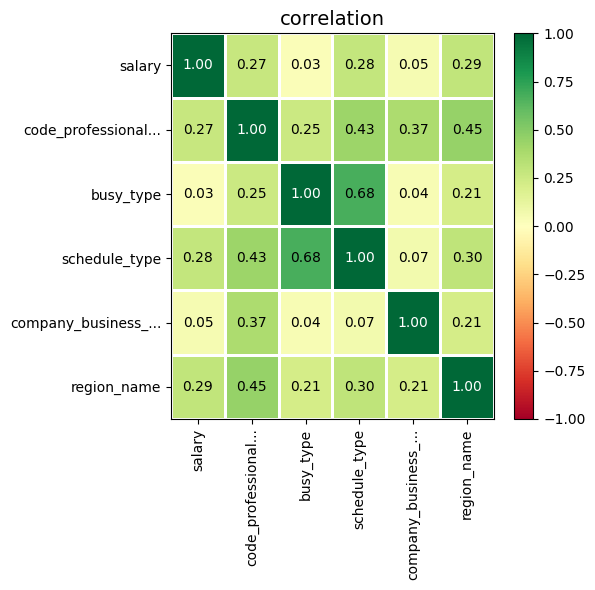

In [18]:
# корреляционный анализ
phik_overview = train[['region_name', 
                       'company_business_size', 
                       'schedule_type', 
                       'busy_type', 
                       'code_professional_sphere', 
                       'salary']].phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(6, 6)
)

Сильнее всего на зарплату влияет регион, тип расписания, код профессиональной сферы

## 3. Подготовка данных

In [19]:
# содание тренировочной и валидационной выборки
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(['salary'], axis=1),
    train['salary'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

Обработка признаков:

- vacancy_name - NLP обработка
- code_professional_sphere - catboost
- busy_type - catboost
- education_requirements - catboost
- hard_skills - NLP обработка
- soft_skills - NLP обработка
- schedule_type - catboost
- company_business_size - catboost
- region_name - catboost
- qualifications - NLP обработка
- responsibilities - NLP обработка

In [20]:
# создание признаков catboost
cb_columns = ['code_professional_sphere', 
                'busy_type', 
                'education_requirements', 
                'schedule_type', 
                'company_business_size', 
                'region_name']

# инициализация энкодера
cb_encoder = CatBoostEncoder(cols=cb_columns)
cb_encoder.fit(X_train[cb_columns], y_train)

# преобразование признаков
X_train_cb = cb_encoder.transform(X_train[cb_columns]).add_suffix('_cb')
X_val_cb = cb_encoder.transform(X_val[cb_columns]).add_suffix('_cb')

In [21]:
# создание признаков NLP
nlp_columns = ['vacancy_name', 
               'hard_skills', 
               'soft_skills', 
               'qualifications', 
               'responsibilities']

train_nlp = X_train[nlp_columns]
val_nlp = X_val[nlp_columns]

In [22]:
# загрузка данных nltk для работы лемматизатора
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
# функция для лемматизации текста
def lemmatize(text):
    '''Функция принимает на вход строку, возвращает лемматизированную строку'''
    
    # очистка от символов
    ru_text = re.sub(r'[^0-9а-яА-ЯёЁ ]', ' ', text)
    no_gap_text = ru_text.split()
    clean_text = " ".join(no_gap_text)
    
    # очистка от стоп слов
    filtered_text = ' '.join([word for word in word_tokenize(clean_text) if not word in stop_words])
    
    # инициализация стеммера
    tokens = word_tokenize(filtered_text)
    lemmatized = ' '.join([stemmer.stem(word) for word in tokens])
    
    return lemmatized

### Лемматизация тренировочной выборки

In [24]:
%%time
# лемматизация тренировочной выборки
train_nlp.loc[:, 'vacancy_name_l'] = train_nlp.loc[:, 'vacancy_name'].apply(lemmatize)

CPU times: total: 56.1 s
Wall time: 56.4 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
%%time
train_nlp.loc[:, 'hard_skills_l'] = train_nlp.loc[:, 'hard_skills'].apply(lemmatize)

CPU times: total: 10.3 s
Wall time: 10.3 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
%%time
train_nlp.loc[:, 'soft_skills_l'] = train_nlp.loc[:, 'soft_skills'].apply(lemmatize)

CPU times: total: 3.39 s
Wall time: 3.38 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
%%time
train_nlp.loc[:, 'qualifications_l'] = train_nlp.loc[:, 'qualifications'].apply(lemmatize)

CPU times: total: 3min 18s
Wall time: 3min 19s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
%%time
train_nlp.loc[:, 'responsibilities_l'] = train_nlp.loc[:, 'responsibilities'].apply(lemmatize)

CPU times: total: 8min 53s
Wall time: 8min 55s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Лемматизация валидационной выборки

In [29]:
%%time
# лемматизация валидационной выборки
val_nlp.loc[:, 'vacancy_name_l'] = val_nlp.loc[:, 'vacancy_name'].apply(lemmatize)

CPU times: total: 19.5 s
Wall time: 19.6 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
%%time
val_nlp.loc[:, 'hard_skills_l'] = val_nlp.loc[:, 'hard_skills'].apply(lemmatize)

CPU times: total: 3.58 s
Wall time: 3.59 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
%%time
val_nlp.loc[:, 'soft_skills_l'] = val_nlp.loc[:, 'soft_skills'].apply(lemmatize)

CPU times: total: 1.2 s
Wall time: 1.21 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
%%time
val_nlp.loc[:, 'qualifications_l'] = val_nlp.loc[:, 'qualifications'].apply(lemmatize)

CPU times: total: 1min 11s
Wall time: 1min 11s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
%%time
val_nlp.loc[:, 'responsibilities_l'] = val_nlp.loc[:, 'responsibilities'].apply(lemmatize)

CPU times: total: 3min 3s
Wall time: 3min 5s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
# сохранение лемматизированных данных
# train_nlp.to_csv('train_nlp.csv')
# val_nlp.to_csv('val_nlp.csv')

In [35]:
# загрузка предварительно лемматизированных данных
#train_nlp = pd.read_csv('train_nlp.csv')
#val_nlp = pd.read_csv('val_nlp.csv')

In [36]:
# удаление необработанных признаков
train_nlp = train_nlp.drop(nlp_columns, axis=1)
val_nlp = val_nlp.drop(nlp_columns, axis=1)

### Векторизация тренировочной выборки

In [37]:
# инициализация экземпляров класса векторизатора
vectorizer_vac_nam = TfidfVectorizer()
vectorizer_hard = TfidfVectorizer()
vectorizer_soft = TfidfVectorizer()
vectorizer_qual = TfidfVectorizer()
vectorizer_resp = TfidfVectorizer()

X_train_tf_idf = pd.DataFrame()

In [38]:
%%time
# преобразование корпуса слов тренировочной выборки
vac_nam = train_nlp['vacancy_name_l'].tolist()
vac_nam_tf_idf = vectorizer_vac_nam.fit_transform(vac_nam)

CPU times: total: 1.72 s
Wall time: 1.78 s


In [39]:
%%time
hard = train_nlp['hard_skills_l'].tolist()
hard_tf_idf = vectorizer_hard.fit_transform(hard)

CPU times: total: 625 ms
Wall time: 805 ms


In [40]:
%%time
soft = train_nlp['soft_skills_l'].tolist()
soft_tf_idf = vectorizer_soft.fit_transform(soft)

CPU times: total: 594 ms
Wall time: 727 ms


In [41]:
%%time
qual = train_nlp['qualifications_l'].tolist()
qual_tf_idf = vectorizer_qual.fit_transform(qual)

CPU times: total: 5.23 s
Wall time: 5.61 s


In [42]:
%%time
resp = train_nlp['responsibilities_l'].tolist()
resp_tf_idf = vectorizer_resp.fit_transform(resp)

CPU times: total: 10.8 s
Wall time: 10.8 s


In [43]:
# соединение матриц
X_train_tf_idf = hstack([vac_nam_tf_idf, hard_tf_idf, soft_tf_idf, qual_tf_idf, resp_tf_idf])

In [44]:
# сохранение матрицы
#save_npz('X_train_tf_idf.npz', X_train_tf_idf, compressed=True)

### Векторизация валидационной выборки

In [45]:
%%time
# преобразование корпуса слов тренировочной выборки
vac_nam_val = val_nlp['vacancy_name_l'].tolist()
vac_nam_val_tf_idf = vectorizer_vac_nam.transform(vac_nam_val)

CPU times: total: 531 ms
Wall time: 524 ms


In [46]:
%%time
hard_val = val_nlp['hard_skills_l'].tolist()
hard_val_tf_idf = vectorizer_hard.transform(hard_val)

CPU times: total: 234 ms
Wall time: 228 ms


In [47]:
%%time
soft_val = val_nlp['soft_skills_l'].tolist()
soft_val_tf_idf = vectorizer_soft.transform(soft_val)

CPU times: total: 203 ms
Wall time: 219 ms


In [48]:
%%time
qual_val = val_nlp['qualifications_l'].tolist()
qual_val_tf_idf = vectorizer_qual.transform(qual_val)

CPU times: total: 1.45 s
Wall time: 1.45 s


In [49]:
%%time
resp_val = val_nlp['responsibilities_l'].tolist()
resp_val_tf_idf = vectorizer_resp.transform(resp_val)

CPU times: total: 3.89 s
Wall time: 3.99 s


In [50]:
# соединение матриц
X_val_tf_idf = hstack([vac_nam_val_tf_idf, hard_val_tf_idf, soft_val_tf_idf, qual_val_tf_idf, resp_val_tf_idf])

In [51]:
# сохранение матрицы
#save_npz('X_val_tf_idf.npz', X_val_tf_idf, compressed=True)

### Добавление признаков catboost

In [52]:
# добавление catboost признаков
X_train_cb_matrix = csr_matrix(X_train_cb.values)
X_val_cb_matrix = csr_matrix(X_val_cb.values)

X_train_sum = hstack([X_train_tf_idf, X_train_cb_matrix])
X_val_sum = hstack([X_val_tf_idf, X_val_cb_matrix])

## 4. Обучение моделей

In [53]:
# пайплайн обучения
pipe_final = Pipeline([
    ('models', LinearRegression())
])

In [76]:
# задание параметров для пайплайна
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()]
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 5)
    },

    # словарь для модели LightGBM()
    {
        'models': [LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE)],
        'models__max_depth': [7, 8],
        'models__learning_rate': [0.1, 1.0]
    }    
]

In [77]:
# инициализация подбора параметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [78]:
%%time
# запуск подбора параметров
grid_search.fit(X_train_sum, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 20.373543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1046091
[LightGBM] [Info] Number of data points in the train set: 286567, number of used features: 19728
[LightGBM] [Info] Start training from score 43427.416227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 LGBMRegressor(max_depth=8, n_jobs=-1, random_state=42))])
Метрика лучшей модели на тренировочной выборке: -17988.241832454907
CPU times: total: 7min 59s
Wall time: 21min 7s


In [79]:
# получение результатов лучших моделей
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,499.766634,14.284865,1.468426,0.264638,"LGBMRegressor(n_jobs=-1, random_state=42)",8.0,0.1,"{'models': LGBMRegressor(n_jobs=-1, random_sta...",-18094.166389,-17878.602756,-17945.111789,-18292.971583,-17730.356645,-17988.241832,192.075990,1
2,395.458260,46.527730,1.151859,0.137108,"LGBMRegressor(n_jobs=-1, random_state=42)",7.0,0.1,"{'models': LGBMRegressor(n_jobs=-1, random_sta...",-18171.841791,-17998.311881,-18046.502318,-18377.533476,-17813.725525,-18081.582998,187.427689,2
4,406.934024,32.791038,1.164225,0.089198,"LGBMRegressor(n_jobs=-1, random_state=42)",7.0,1.0,"{'models': LGBMRegressor(n_jobs=-1, random_sta...",-18531.244950,-18214.377229,-18221.859717,-18715.514630,-18117.274538,-18360.054213,225.796302,3
5,315.248803,54.837357,0.962300,0.183350,"LGBMRegressor(n_jobs=-1, random_state=42)",8.0,1.0,"{'models': LGBMRegressor(n_jobs=-1, random_sta...",-18462.379756,-18421.067076,-18281.247377,-18684.646186,-18352.130608,-18440.294201,136.845941,4
0,6.169516,0.552687,0.049271,0.011668,LinearRegression(),NaN,NaN,{'models': LinearRegression()},-20425.416109,-20196.349601,-20238.858471,-20149.538772,-20147.746297,-20231.581850,102.591859,5
1,97.885456,4.016589,0.194343,0.056330,DecisionTreeRegressor(random_state=42),4.0,NaN,{'models': DecisionTreeRegressor(random_state=...,-22893.468450,-22586.770397,-22610.975585,-23190.625788,-22631.569717,-22782.681987,232.116843,6


In [80]:
# проверка лучшей модели на валидационной выборке
pred = grid_search.best_estimator_.predict(X_val_sum)

print("RMSE валидационной выборки:", root_mean_squared_error(y_val, pred))

c:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RMSE валидационной выборки: 17742.453435535022


## 5. Получение предсказания на тестовой выборке

In [81]:
# преобразование признаков тестовой выборки
X_test_cb = cb_encoder.transform(test[cb_columns]).add_suffix('_cb')

In [82]:
# подготовка признаков nlp
test_nlp = test[nlp_columns]

In [83]:
%%time
# лемматизация тестовой выборки
test_nlp.loc[:, 'vacancy_name_l'] = test_nlp.loc[:, 'vacancy_name'].apply(lemmatize)

CPU times: total: 34.6 s
Wall time: 36.1 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [84]:
%%time
test_nlp.loc[:, 'hard_skills_l'] = test_nlp.loc[:, 'hard_skills'].apply(lemmatize)

CPU times: total: 6.5 s
Wall time: 6.69 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
%%time
test_nlp.loc[:, 'soft_skills_l'] = test_nlp.loc[:, 'soft_skills'].apply(lemmatize)

CPU times: total: 2.12 s
Wall time: 2.15 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [86]:
%%time
test_nlp.loc[:, 'qualifications_l'] = test_nlp.loc[:, 'qualifications'].apply(lemmatize)

CPU times: total: 2min
Wall time: 2min 2s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [87]:
%%time
test_nlp.loc[:, 'responsibilities_l'] = test_nlp.loc[:, 'responsibilities'].apply(lemmatize)

CPU times: total: 5min 3s
Wall time: 5min 5s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [88]:
# удаление необработанных признаков
test_nlp = test_nlp.drop(nlp_columns, axis=1)

In [89]:
%%time
# преобразование корпуса слов тестовой выборки
vac_nam_test = test_nlp['vacancy_name_l'].tolist()
vac_nam_test_tf_idf = vectorizer_vac_nam.transform(vac_nam_test)

CPU times: total: 875 ms
Wall time: 861 ms


In [90]:
%%time
hard_test = test_nlp['hard_skills_l'].tolist()
hard_test_tf_idf = vectorizer_hard.transform(hard_test)

CPU times: total: 422 ms
Wall time: 430 ms


In [91]:
%%time
soft_test = test_nlp['soft_skills_l'].tolist()
soft_test_tf_idf = vectorizer_soft.transform(soft_test)

CPU times: total: 344 ms
Wall time: 335 ms


In [92]:
%%time
qual_test = test_nlp['qualifications_l'].tolist()
qual_test_tf_idf = vectorizer_qual.transform(qual_test)

CPU times: total: 2.47 s
Wall time: 2.46 s


In [93]:
%%time
resp_test = test_nlp['responsibilities_l'].tolist()
resp_test_tf_idf = vectorizer_resp.transform(resp_test)

CPU times: total: 6.03 s
Wall time: 6.03 s


In [94]:
# соединение матриц
X_test_tf_idf = hstack([vac_nam_test_tf_idf, hard_test_tf_idf, soft_test_tf_idf, qual_test_tf_idf, resp_test_tf_idf])

In [95]:
# добавление catboost признаков
X_test_cb_matrix = csr_matrix(X_test_cb.values)

X_test_sum = hstack([X_test_tf_idf, X_test_cb_matrix])

In [96]:
# получение предсказаний на тестовой выборке
test_pred = grid_search.best_estimator_.predict(X_test_sum)

c:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [97]:
# запись submission file
submission = pd.Series(test_pred, index=test.index, name='salary')
submission.to_csv('submission.csv')